In [6]:
import torch

Load Dataset , Resize and Crop Images to 64 x 64 pixels.  
Normalise the pixel values with mean and Std Dev. of 0.5 for each colour channel (RGB).  
This ensures pixel values are in the range (-1,1) which is more convenient for training the discriminator.

In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [8]:
img_size = 64
batch_size = 128
stats = (0.5,0.5,0.5) , (0.5,0.5,0.5) # means and std of 0.5 for each RGB colour channel

In [9]:
data_dir = "Anime Face Dataset/"

train_ds = ImageFolder(data_dir , transform = T.Compose([
    T.Resize(img_size),
    T.CenterCrop(img_size),
    T.ToTensor(),        # converts the image into tensor
    T.Normalize(*stats)  # Normalizes a tensor image with mean and standard deviation.
])) 

train_dl = DataLoader(train_ds , batch_size , shuffle = True , num_workers=3 , pin_memory=True)
# DataLoader is used to load data in batches during training , used to handle large datsets efficiently.

View some Images from a Training Batch.
For this we have to first denormalise the image tensors.

In [10]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]


def show_imgs(images , nmax = 64):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
    for images,_ in dl:
        show_imgs(images,nmax)
        break

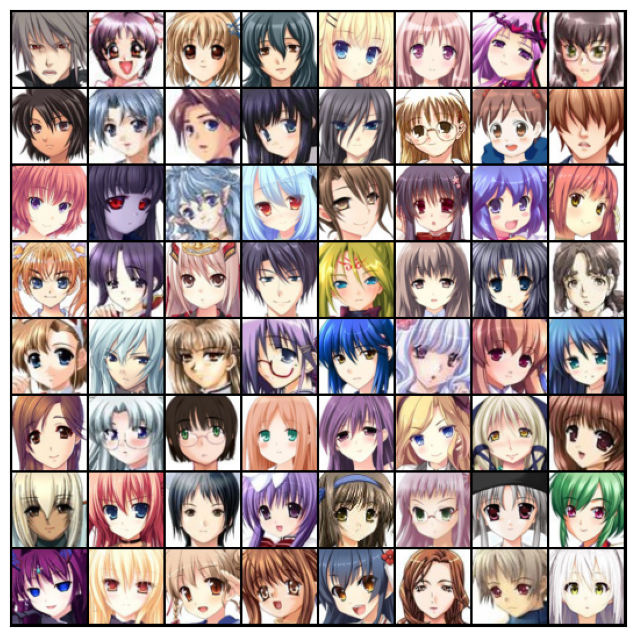

In [11]:
show_batch(train_dl)

In [12]:
if torch.cuda.is_available():
    print("yo")

yo


In [13]:
def get_default_device(): # get available device
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data,device): # function moves the data (tensors) to the specified device ; if input is list/tuple function is applied recursively
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True) # moves data to device for faster computation

class DeviceDataLoader():

    def __init__(self,dl,device): # initialise DeviceDataLoader class
        self.dl = dl
        self.device = device

    def __iter__(self): # makes the DDL class iterable ,  ensures that each batch of data is placed on the correct device before being returned.
        for b in self.dl:
            yield to_device(b,self.device)
            # yield turns any expression that is given with it into a generator object and returns it to the caller.
            # return statement terminates the execution of the function whereas, the yield statement only pauses the execution of the function.

    def __len__(self): #  returns the length (number of batches) of the wrapped data loader
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl , device)

## Discriminator Network : Classifies Input images into Real or 'Generated'

Use a CNN to output a single number output for every image.  
Use a stride of 2 to progressively reduce the size of output feature map.

In [16]:
import torch.nn as nn
discriminator = nn.Sequential(
    # input = 3 (channels) x 64 x 64 (dimensions of image)
    nn.Conv2d(3, 64, kernel_size=4 , stride = 2 , padding = 1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2 , inplace=True),
    # output = 64 x 32 x 32 (64 channels , stride of 2 halves dimesion of the image)

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    # output = 128 x 16 x 16

    nn.Conv2d(128,256,kernel_size=4,stride=2 , padding=1 , bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    # output = 256 x 8 x 8

    nn.Conv2d(256,512,kernel_size=4,stride=2 , padding=1 , bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    # output = 512 x 4 x 4

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False), # The final convolution compresses the feature maps to a single value per image.
    # output = 1 x 1 x 1

    nn.Flatten(), # convert the multi-dimensional output from the previous layer into a one-dimensional array
    nn.Sigmoid()  # takes input and maps it to a value between 0 and 1, which can be interpreted as a probability
)

1. Stride of 2 halves spatial dimensions of the input
2. Padding of 1 preserves spatial dimensions
3. BatchNorm2d normalises the output of the convolution to stabilise training
4. Bias = False dosent add the bias term to the output feature map
5. LeakyReLU Activation Function : f(x)=max(0.01*x , x)  
   returns x , if x is positive else a very small negative value
   In the above code , a = 0.2 has been used instead of 0.01.

Why use Leaky ReLU ?   

Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.

In [17]:
discriminator = to_device(discriminator , device) # call the discriminator to GPU/CPU

## Generator Network : 

Input of a Generator is a vector/matrix of random numbers (noise) , which is used as a seed for generating images.  
This Generator inputs a latent tensor of size 128 x 1 x 1 and outputs an image tensor of shape 3 x 64 x 64.   
To achieve this , ConvTranspose2d layer from pytorch is used , which performs the transposed convolution operation.

In [18]:
latent_size = 128

generator = nn.Sequential(

    # input : latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size , 512 , kernel_size= 4 , stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # output: 512 x 4 x 4

    nn.ConvTranspose2d(512 , 256, kernel_size= 4 , stride = 2 , padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # output: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128 , kernel_size= 4 , stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # output:  128 x 16 x 16

    nn.ConvTranspose2d(128 , 64 , kernel_size= 4 , stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # output: 64 x 32 x 32

    nn.ConvTranspose2d(64 , 3 , kernel_size= 4 , stride = 2, padding = 1, bias = False),
    nn.Tanh(),
    # output: 3 x 64 x 64
    
)

1. ReLU instead of Leaky ReLU? : ReLu workd fine , there is no need of a leaky relu function for generators.
2. Tanh() Activation Function :
   The tanh() function reduces values into the range (-1 , 1).
   Hence, the activation function changes the pixel intensities from the ConvTranspose layer from a real number to between (-1 , 1).
   (Also at the start , we normalised the input images to have pixel values between (-1,1)) 

torch.Size([128, 3, 64, 64])


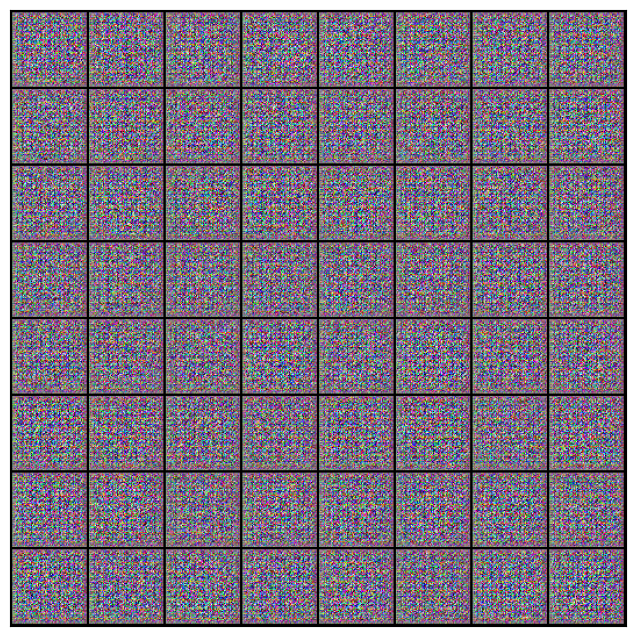

In [19]:
# try the generator:
xb = torch.randn(batch_size , latent_size , 1 , 1) # random latent tensors
fake_images = generator(xb) # images created by the generator are fake
print(fake_images.shape)
show_imgs(fake_images) # show_imgs() denormalises the image tensors

In [20]:
generator = to_device(generator , device) # move the generator to the GPU/CPU

## Training the Discriminator :
The discriminator can later be used to train the generator.  
Loss Function : Binary Cross-Entropy Loss Function to quantify how well it differentiates between real and generated images.

In [21]:
def train_discriminator(real_images , opt_d): # inputs real images and the discriminator optimiser function

    opt_d.zero_grad() # clear the discriminator gradients (It is beneficial to zero out gradients when building a neural network.)

    # pass the real images to the discriminator
    real_preds = discriminator(real_images) # get prediction scores of each image in the batch (Predicted Scores)
    real_targets = torch.ones(real_images.size(0) , 1 , device=device) # Since images are real , targets must be 1. (Ground Truth)
    real_loss = F.binary_cross_entropy(real_preds , real_targets) # Measure Binary Cross Entropy between the target and input probabilities.
    real_score = torch.mean(real_preds).item() #  average prediction score for real images. (higher score is better)
    
    # introduce the fake images to the discriminator :

    # first generate the fake images
    latent = torch.randn(batch_size , latent_size , 1 , 1 , device=device)
    fake_images = generator(latent)

    # pass fake images to the discriminator :
    fake_targets = torch.zeros(fake_images.size(0) , 1 , device=device) # since images are fake , target is 0
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds , fake_targets) 
    fake_score = torch.mean(fake_preds).item() # average prediction score for fake images (lower is better).

    # update the weights
    loss = real_loss + fake_loss
    loss.backward() # calculates the gradients of the loss with respect to all trainable parameters using the chain rule.
    opt_d.step() # update the weights of the discriminator using the computed gradients from the backward() step
    return loss.item() , real_score , fake_score

## Training the Generator
As the outputs of the generator are images , not obvious how to train the generator.  
Hence , trick is to use the discriminator as part of the loss function of the generator :  
1. Generate a batch of images using generator and pass it to the discriminator.  
2. Calculate the loss by setting target to 1. (Generators objective is to fool the discriminator , so want to generate images as close to real).
3. Perform Gradient Descent to update weights of the generator , to become better at fooling the discriminator.

In [22]:
def train_generator(opt_g): # input the optimiser for the generator
    
    opt_g.zero_grad() # clear the gradients

    # generate fake images
    latent = torch.randn(batch_size , latent_size , 1 , 1 , device=device)
    fake_images = generator(latent)

    # aim is to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size , 1 , device=device)  # set target as 1 (try to generate real images)
    loss = F.binary_cross_entropy(preds , targets)

    # update weights
    loss.backward()  # calculate the gradients
    opt_g.step()     # update the weights

    return loss.item()

In [23]:
# save the intermediate generator outputs so we can visually inspect the images produced

from torchvision.utils import save_image
import os
sample_dir = 'Generated'
os.makedirs(sample_dir , exist_ok=True)

def save_samples(index , latent_tensors , show=True):

    fake_images = generator(latent_tensors)
    fake_fname = 'generated-image-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images) , os.path.join(sample_dir , fake_fname),nrow=8)
    print('Saving',fake_fname)
    if show:
        fig,ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-image-0000.png


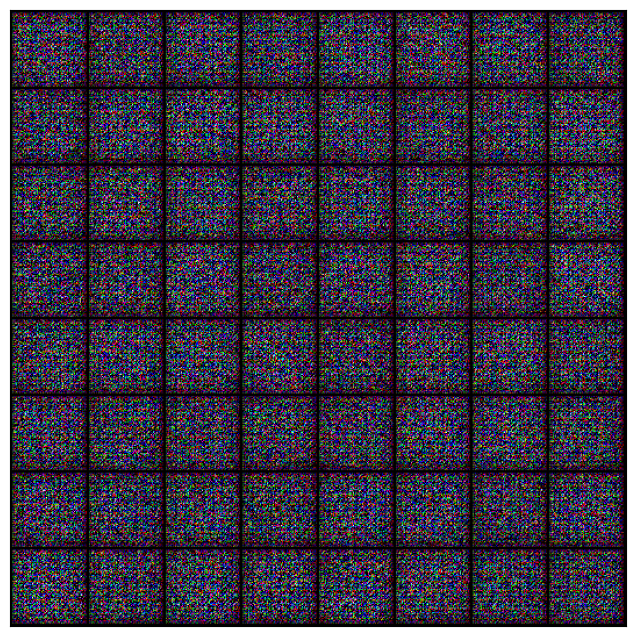

In [24]:
# fix a latent vector to see how generated images evolve with epochs
fixed_latent = torch.randn(64,latent_size,1,1,device=device) # batch of 64 is passed instead of 128 , so that images can be displayed in a 8x8 grid
# save initial set of images before training model
save_samples(0,fixed_latent)

## Full Training Loop : Train both the generator and the discriminator on batches of train data.
Adam Optimiser is used with custom parameters to work in GANS

In [33]:
from tqdm.notebook import tqdm   # shows a progress bar for each epoch
import torch.nn.functional as F

def fit(epochs , learning_rate , start_index=1):

    torch.cuda.empty_cache()

    # init. losses and scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # optimisers for generator and discriminator
    opt_g = torch.optim.Adam(generator.parameters() , lr = learning_rate , betas = (0.5,0.999)) # beta values from pytorch doc
    opt_d = torch.optim.Adam(discriminator.parameters() , lr = learning_rate , betas = (0.5,0.999))
    
    for epoch in range(epochs):  # iterate over training epochs
        for real_images , _ in tqdm(train_dl):  # iterate over real_images from training data , _ corresponds to labels of the images
            
            # train the discriminator
            loss_d,real_score,fake_score = train_discriminator(real_images,opt_d)

            # train the generator
            loss_g = train_generator(opt_g)

        # append the losses and scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # print epoch info and scores
        print("Epoch [{}/{}] , loss_g: {:.4f} , loss_d: {:.4f} , real_score: {:.4f} , fake_score: {:.4f}".format(epoch+1,epochs,loss_g,loss_d,real_score,fake_score))

        # save the generated images
        save_samples(epoch+start_index,fixed_latent,show=False)
    return losses_g , losses_d , real_scores , fake_scores

In [50]:
lr = 0.0002 # learning rate of 0.0002 recommended from pytorch documentattion
epochs = 25

history = fit(epochs,lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25] , loss_g: 4.6087 , loss_d: 0.0418 , real_score: 0.9800 , fake_score: 0.0196
Saving generated-image-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25] , loss_g: 6.1562 , loss_d: 0.0809 , real_score: 0.9452 , fake_score: 0.0200
Saving generated-image-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25] , loss_g: 4.9994 , loss_d: 0.1072 , real_score: 0.9381 , fake_score: 0.0359
Saving generated-image-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25] , loss_g: 5.1542 , loss_d: 0.0812 , real_score: 0.9477 , fake_score: 0.0234
Saving generated-image-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25] , loss_g: 9.6993 , loss_d: 0.2578 , real_score: 0.9764 , fake_score: 0.1839
Saving generated-image-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25] , loss_g: 6.0702 , loss_d: 0.1751 , real_score: 0.9495 , fake_score: 0.1029
Saving generated-image-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25] , loss_g: 2.2612 , loss_d: 0.5240 , real_score: 0.6899 , fake_score: 0.0056
Saving generated-image-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25] , loss_g: 4.8289 , loss_d: 0.1183 , real_score: 0.9485 , fake_score: 0.0522
Saving generated-image-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25] , loss_g: 3.7700 , loss_d: 0.2162 , real_score: 0.8836 , fake_score: 0.0438
Saving generated-image-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25] , loss_g: 4.9605 , loss_d: 0.0863 , real_score: 0.9524 , fake_score: 0.0273
Saving generated-image-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25] , loss_g: 5.7306 , loss_d: 0.0815 , real_score: 0.9846 , fake_score: 0.0614
Saving generated-image-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25] , loss_g: 5.2279 , loss_d: 0.1454 , real_score: 0.9062 , fake_score: 0.0238
Saving generated-image-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25] , loss_g: 5.3934 , loss_d: 0.0752 , real_score: 0.9415 , fake_score: 0.0061
Saving generated-image-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25] , loss_g: 8.5476 , loss_d: 0.0751 , real_score: 0.9443 , fake_score: 0.0073
Saving generated-image-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25] , loss_g: 4.9296 , loss_d: 0.1280 , real_score: 0.9450 , fake_score: 0.0561
Saving generated-image-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25] , loss_g: 6.4593 , loss_d: 0.0922 , real_score: 0.9901 , fake_score: 0.0714
Saving generated-image-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25] , loss_g: 5.4201 , loss_d: 0.0513 , real_score: 0.9788 , fake_score: 0.0278
Saving generated-image-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25] , loss_g: 6.6927 , loss_d: 0.1433 , real_score: 0.9761 , fake_score: 0.1043
Saving generated-image-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25] , loss_g: 3.7889 , loss_d: 0.1757 , real_score: 0.9306 , fake_score: 0.0716
Saving generated-image-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25] , loss_g: 3.8952 , loss_d: 0.0330 , real_score: 0.9946 , fake_score: 0.0259
Saving generated-image-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25] , loss_g: 4.0184 , loss_d: 0.1650 , real_score: 0.9481 , fake_score: 0.0713
Saving generated-image-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25] , loss_g: 5.4492 , loss_d: 0.0754 , real_score: 0.9755 , fake_score: 0.0446
Saving generated-image-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25] , loss_g: 4.1134 , loss_d: 0.1265 , real_score: 0.9175 , fake_score: 0.0241
Saving generated-image-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25] , loss_g: 4.5706 , loss_d: 0.0649 , real_score: 0.9687 , fake_score: 0.0297
Saving generated-image-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25] , loss_g: 4.4333 , loss_d: 0.1019 , real_score: 0.9411 , fake_score: 0.0316
Saving generated-image-0025.png


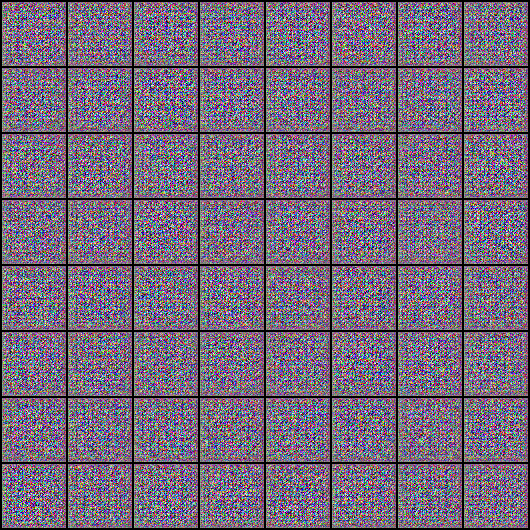

In [51]:
# check images after 1st , 5th and 10th epochs of training:

from IPython.display import Image
Image('Generated/generated-image-0000.png')

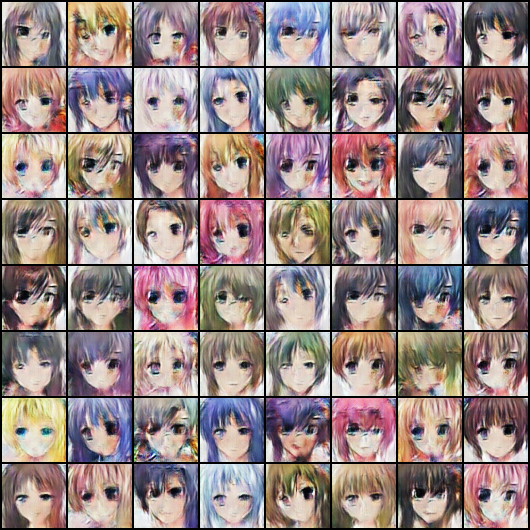

In [52]:
Image('Generated/generated-image-0005.png')

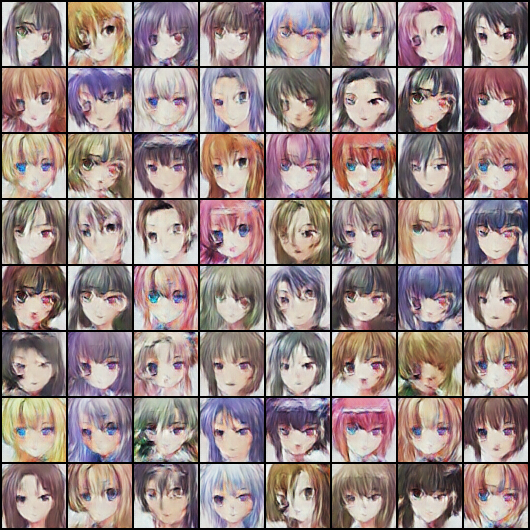

In [53]:
Image('Generated/generated-image-0010.png')

In [54]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

## Visualise Loss of Generator and Discriminator over time:
Generators Loss must decrease over time , while discriminator loss not getting too high.

In [55]:
losses_g, losses_d, real_scores, fake_scores = history

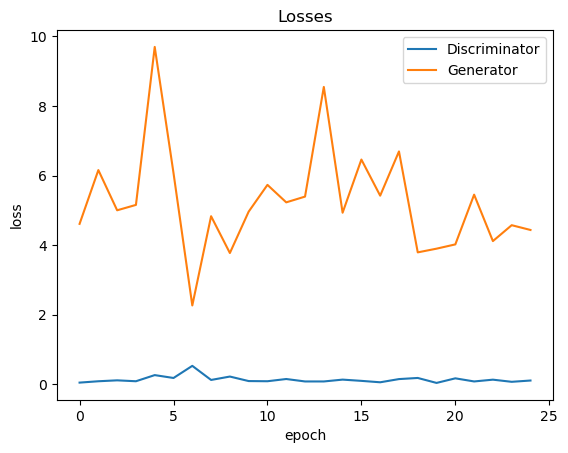

In [56]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

We can see here that the performance of the discriminator is good.

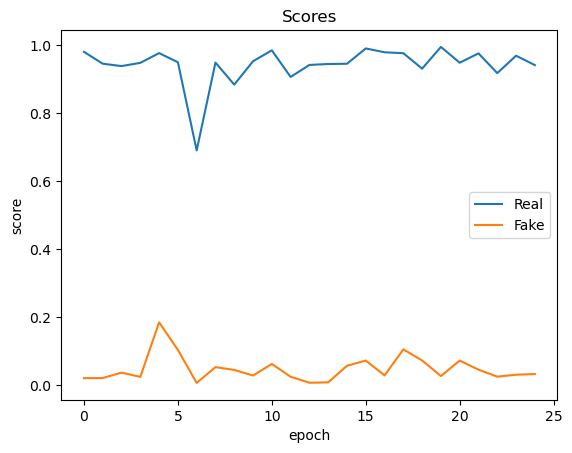

In [58]:
# visualise the scores over the epochs

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');